Reference: Tensorflow tutorials(https://www.tensorflow.org/tutorials/sequences/text_generation)

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
# Read, then decode for py2 compat.
text = open('huge_c.txt', 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 26346 characters


In [3]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

85 unique characters


In [4]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [5]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder = True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'// SPDX-License-Identifier: GPL-2.0\n#include "audit.h"\n#include <linux/fsnotify_backend.h>\n#include <'
'linux/namei.h>\n#include <linux/mount.h>\n#include <linux/kthread.h>\n#include <linux/refcount.h>\n#inclu'
'de <linux/slab.h>\n\nstruct audit_tree;\nstruct audit_chunk;\n\nstruct audit_tree {\n\trefcount_t count;\n\tin'
't goner;\n\tstruct audit_chunk *root;\n\tstruct list_head chunks;\n\tstruct list_head rules;\n\tstruct list_h'
'ead list;\n\tstruct list_head same_root;\n\tstruct rcu_head head;\n\tchar pathname[];\n};\n\nstruct audit_chun'


In [6]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [7]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '// SPDX-License-Identifier: GPL-2.0\n#include "audit.h"\n#include <linux/fsnotify_backend.h>\n#include '
Target data: '/ SPDX-License-Identifier: GPL-2.0\n#include "audit.h"\n#include <linux/fsnotify_backend.h>\n#include <'


In [8]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 16 ('/')
  expected output: 16 ('/')
Step    1
  input: 16 ('/')
  expected output: 2 (' ')
Step    2
  input: 2 (' ')
  expected output: 44 ('S')
Step    3
  input: 44 ('S')
  expected output: 42 ('P')
Step    4
  input: 42 ('P')
  expected output: 31 ('D')


In [9]:
# Batch size
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [10]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(vocab), embedding_dim,
                              batch_input_shape=[BATCH_SIZE, None]))
model.add(tf.keras.layers.CuDNNGRU(rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True))
model.add(tf.keras.layers.Dense(len(vocab)))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21760     
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 85)            87125     
Total params: 4,047,189
Trainable params: 4,047,189
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 85) # (batch_size, sequence_length, vocab_size)


In [13]:
def loss(labels, logits):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [14]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_c_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [15]:
EPOCHS=200

# history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/200
4/4 [==============================] - 0s 82ms/step - loss: 4.3378
Epoch 2/200
4/4 [==============================] - 0s 74ms/step - loss: 4.8581
Epoch 3/200
4/4 [==============================] - 0s 77ms/step - loss: 4.1511
Epoch 4/200
4/4 [==============================] - 0s 83ms/step - loss: 3.9667
Epoch 5/200
4/4 [==============================] - 0s 81ms/step - loss: 3.7485
Epoch 6/200
4/4 [==============================] - 0s 79ms/step - loss: 3.4750
Epoch 7/200
4/4 [==============================] - 0s 78ms/step - loss: 3.2431
Epoch 8/200
4/4 [==============================] - 0s 86ms/step - loss: 3.1185
Epoch 9/200
4/4 [==============================] - 0s 79ms/step - loss: 2.9910
Epoch 10/200
4/4 [==============================] - 0s 77ms/step - loss: 2.8767
Epoch 11/200
4/4 [==============================] - 0s 76ms/step - loss: 2.7564
Epoch 12/200
4/4 [==============================] - 0s 76ms/step - loss: 2.6457
Epoch 13/200
4/4 [==============================]

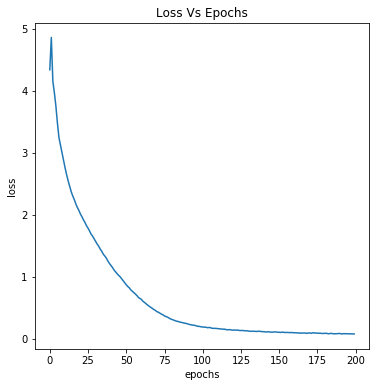

In [16]:
plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.title('Loss Vs Epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [20]:
checkpoint_dir = './training_checkpoints/ckpt_c_200'
# tf.train.latest_checkpoint(checkpoint_dir)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(vocab), embedding_dim,
                              batch_input_shape=[1, None]))
model.add(tf.keras.layers.CuDNNGRU(rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True))
model.add(tf.keras.layers.Dense(len(vocab)))

model.load_weights(checkpoint_dir)

model.build(tf.TensorShape([1, None]))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21760     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (1, None, 1024)           3938304   
_________________________________________________________________
dense_2 (Dense)              (1, None, 85)             87125     
Total params: 4,047,189
Trainable params: 4,047,189
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [22]:
print(generate_text(model, start_string=u"struct"))

struct audit_tree *tree)
{
	put_tree *tree)
{
	return tree->pathname, 0, &path);
	if (IS_ERR(mark))
		return;
	out_mutex:
	mutex_unlock(&audit_tree_group->mark_mutex);
		return -ENOMEM;
	}

	mark = ale;
		fsnotify_free_mark(mark);
		fsnotify_put_mark(mark);
		kfree(chunk);
		return 0;
	}
	replace_mark_chunk(old->mark, new);
	/*
	 /      struct audit_chunk *chunk)
{
	struct audit_chunk *old;

	assert_spin_locted->chunks, list) {
			list_move(&owner->list, &prune_list);
			need_prune = 1;
		} else {
		struct path path1, path2;
	struct vfsmount *tagged;
	int err;

	err = kern_path(new, 0, &path2);
		if (!err) {
			good_one = canlic inline struct audit_tree_mark *audit_mark(struct fsnotify_mark *mark,
				   err)
			goto skip_it;

		root_mnt = collect_mounts(&path);
		path_put(&path);
		if (IS_ERR(rootagner) /* reorder */
	for (p = tree->chunks.next; p != &tree->chunks; p = q) {
		struct node *node = list_entry(prune_list.next,
					struct audit_chunk *chunk = from_chunk(mark) != chunk)
		